# 描述 & 可视化 & 结果汇总

本 notebook 的使用顺序在项目最后, 专注于: 
- 描述性统计
- 进行一些可视化
- 对分析结果进行整理 得到表格数据的 $\LaTeX$ 的代码

In [1]:
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimSun']  # 中文设定宋体
plt.rcParams['axes.unicode_minus'] = False   # 解决负号 '-' 显示为方块的问题

from seaborn import heatmap # 热力图

def get_data_by_year(df, start_year=1995, end_year=2024):
    """
    根据 year_month 列提取指定年份的数据
    """
    df_res = df.copy() 
    df_res['year_month'] = pd.to_datetime(df_res['year_month'], format='%Y-%m')
    df_res = df_res[(df_res['year_month'].dt.year >= start_year) & (df_res['year_month'].dt.year <= end_year)]
    return df_res

def load_results_pickle(filename: str):
    """
    从pickle文件加载结果
    
    Parameters:
    filename: pickle文件名
    
    Returns:
    加载的结果列表
    """
    with open(filename, 'rb') as f:  # 'rb'表示二进制读取
        all_results = pickle.load(f)
    
    print(f"已从 {filename} 加载结果")
    return all_results

## 数据说明

### 上证指数 & 上市公司数量

In [3]:
# 读取交易数据
df = pd.read_csv("data/raw/daily_return.csv").loc[:,['date','code']]
df['date'] = pd.to_datetime(df['date'])

# 选择 1995 年的数据
count = []
for y in range(1995, 2024+1): 
    count.append( df[df['date'].dt.year == y]['code'].nunique() )

In [9]:
# 上证行情
path = "data/raw/sz_index.csv"

df_sz = pd.read_csv(path)
df_sz.columns = ['date', 'sz_index']
df_sz['date'] = pd.to_datetime(df_sz['date'])
df_sz.head()

,date,sz_index
0,2024-12-31,3351.76
1,2024-12-30,3407.33
2,2024-12-27,3400.14
3,2024-12-26,3398.08
4,2024-12-25,3393.35


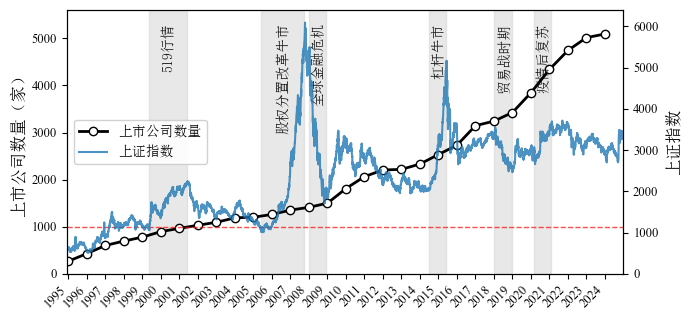

In [10]:
import matplotlib.dates as mdates

# count: 长度30的列表或数组，对应1995-2024年
# df_sz: DataFrame，包含'date'列和'sz_index'列，'date'为datetime类型

fig, ax = plt.subplots(figsize=(7, 3.3))

# ============== 左侧y轴：上市公司数量 ==============
# 将年份转换为datetime格式，以便与上证指数数据对齐
years = pd.date_range(start='1995-01-01', end='2024-12-31', freq='YS')  # 年初

# 确保count数据长度与年份匹配
ax.plot(years, count, color='black', linewidth=2, label='上市公司数量', marker='o', markerfacecolor='white')

# 添加参考线
ax.axhline(y=1000, color='red', linestyle='--', linewidth=1, alpha=0.7)
# ax.axhline(y=5000, color='black', linestyle='--', linewidth=1, alpha=0.7)

# 添加参考线标签
# ax.text(years[0], 1050, '1000家', fontsize=9, va='bottom')
# ax.text(years[0], 5050, '5000家', fontsize=9, va='bottom')

# 设置左侧y轴标签
ax.set_ylabel('上市公司数量（家）', fontsize=12, fontweight='bold', color='black')
ax.tick_params(axis='y', labelcolor='black')

# 设置左侧y轴范围
ax.set_ylim(0, max(count) * 1.1)

# ============== 右侧y轴：上证指数 ==============
ax2 = ax.twinx()

# 确保上证指数数据的时间范围包含1995-2024
# 如果df_sz数据是日频，可以取每年最后一个交易日的数据
# if len(df_sz) > 30:  # 如果是高频数据，需要重采样
#     # 方法1：取每年最后一个观测值
#     df_sz_yearly = df_sz.resample('Y', on='date').last().reset_index()
#     ax2.plot(df_sz_yearly['date'], df_sz_yearly['sz_index'], 
#              linewidth=1.5, label='上证指数', alpha=0.8)
# else:  # 如果已经是年频数据
#     ax2.plot(df_sz['date'], df_sz['sz_index'], 
#              linewidth=1.5, label='上证指数', alpha=0.8)
ax2.plot(df_sz['date'], df_sz['sz_index'],
         linewidth=1.5, label='上证指数', alpha=0.8)

# 设置右侧y轴标签
ax2.set_ylabel('上证指数', fontsize=12, fontweight='bold', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# 设置右侧y轴范围
ax2.set_ylim(0, max(df_sz['sz_index']) * 1.05)

# ============== 添加阴影区域标记重要时期 ==============
# 用半透明阴影标记重要市场时期
important_periods = [
    (pd.Timestamp('1999-05-01'), pd.Timestamp('2001-06-01'), '519行情', 0.5, 'lightgray'),
    (pd.Timestamp('2005-06-01'), pd.Timestamp('2007-10-01'), '股权分置改革牛市', 0.5, 'lightgray'),
    (pd.Timestamp('2008-01-01'), pd.Timestamp('2008-12-01'), '全球金融危机', 0.5, 'lightgray'),
    (pd.Timestamp('2014-07-01'), pd.Timestamp('2015-06-01'), '杠杆牛市', 0.5, 'lightgray'),
    (pd.Timestamp('2018-01-01'), pd.Timestamp('2019-01-01'), '贸易战时期', 0.5, 'lightgray'),
    (pd.Timestamp('2020-03-01'), pd.Timestamp('2021-02-01'), '疫情后复苏', 0.5, 'lightgray'),
]

for start, end, label, alpha, color in important_periods:
    ax.axvspan(start, end, alpha=alpha, color=color)
    # 在中间位置添加标签
    mid_date = start + (end - start) / 2
    ax.text(mid_date, ax.get_ylim()[1] * 0.95, label, 
           ha='center', va='top', fontsize=10, rotation=90, alpha=0.9)

# ============== x轴设置 ==============
# 设置x轴为年份格式
ax.xaxis.set_major_locator(mdates.YearLocator(1))  # 每5年一个主刻度
# ax.xaxis.set_minor_locator(mdates.YearLocator(1))  # 每年一个次刻度

# 设置x轴标签格式
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# 旋转x轴标签
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

# 设置x轴范围
ax.set_xlim(pd.Timestamp('1994-12-01'), pd.Timestamp('2024-12-31'))

# ============== 网格和标题 ==============
# 添加网格
# ax.grid(True, alpha=0.3, linestyle='--', which='both')

# 添加图例
# 由于双y轴，需要分别获取句柄和标签
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, 
          loc='center left', fontsize=10, framealpha=0.9)

# 添加标题
# ax.set_title('中国A股市场上市公司数量与上证指数走势（1995-2024）', 
#              fontsize=12, fontweight='bold', pad=15)

# ============== 美观调整 ==============
# 设置刻度字体
for label in ax.get_xticklabels() + ax.get_yticklabels() + ax2.get_yticklabels():
    label.set_fontname('Times New Roman')
    label.set_fontsize(9)

# 调整布局
plt.tight_layout()

# 保存图片
plt.savefig("normal_lasso_result/上市公司数量与上证指数.pdf", 
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

### 因子描述性统计

In [2]:
df_factor = pd.read_csv("data/preprocessed/aligned_data.csv")
df_factor = df_factor.drop(columns=['Unnamed: 0', 'code', 'year_month', 'excess_return'])
df_factor.head()

,MOM_12_2,STR_1,LTR_36_13,IdioVol,MAX,Beta,RealizedVol,ZeroRatio,AutoCorr,Size,BM
0,-0.998844,-0.337333,-0.970680,0.031403,0.051933,0.597985,0.032262,0.000000,0.246332,3.323664e+09,0.968413
1,-0.998375,-0.211557,-0.985852,0.037145,0.078567,0.665990,0.040973,0.000000,-0.040595,3.323664e+09,0.968413
2,-0.997541,-0.393728,-0.991958,0.022477,0.048193,0.721118,0.031003,0.000000,0.017741,3.323664e+09,0.968413
3,-0.997705,-0.318954,-0.995596,0.022976,0.016569,0.716568,0.030402,0.142857,-0.427057,3.323664e+09,0.968413
4,-0.996688,-0.109651,-0.997687,0.037988,0.100867,0.762185,0.046490,0.000000,-0.501871,3.323664e+09,0.968413


In [ ]:
fac_des = df_factor.describe().T
fac_des.index = [s.replace("_", f"\_") for s in fac_des.index]
fac_des.columns = ['样本量', '均值', '标准差', '最小值', '25\%', '中位数', '75\%', '最大值']
fac_des['样本量'] = fac_des['样本量'].astype("int")

# 把市值改成 10e-9
fac_des.loc['Size', :] = fac_des.loc['Size', :] / 1e9
fac_des = fac_des.rename(index={'Size': 'Size $\\times 10^{-9}$'})

# 清除样本量这一列
fac_des = fac_des.drop(columns=['样本量'])
# fac_des.loc['MOM\_12\_2', '样本量'] = "\multirow{11}{*}{202603}"

# 打印 latex 表格
print( fac_des.to_latex(float_format='%.2f', na_rep="") )

\begin{tabular}{lrrrrrrr}
\toprule
 & 均值 & 标准差 & 最小值 & 25\% & 中位数 & 75\% & 最大值 \\
\midrule
MOM\_12\_2 & -0.67 & 0.18 & -1.00 & -0.76 & -0.68 & -0.60 & 5.52 \\
STR\_1 & -0.10 & 0.13 & -0.74 & -0.17 & -0.10 & -0.04 & 3.76 \\
LTR\_36\_13 & -0.82 & 0.49 & -1.00 & -0.98 & -0.96 & -0.91 & 20.81 \\
IdioVol & 0.02 & 0.01 & 0.00 & 0.01 & 0.02 & 0.03 & 0.16 \\
MAX & 0.05 & 0.03 & -0.01 & 0.03 & 0.04 & 0.07 & 0.46 \\
Beta & 1.10 & 0.34 & -0.61 & 0.87 & 1.10 & 1.32 & 3.12 \\
RealizedVol & 0.03 & 0.01 & 0.00 & 0.02 & 0.02 & 0.03 & 0.17 \\
ZeroRatio & 0.04 & 0.05 & 0.00 & 0.00 & 0.05 & 0.05 & 0.52 \\
AutoCorr & -0.04 & 0.21 & -0.84 & -0.19 & -0.05 & 0.10 & 0.91 \\
Size $\times 10^{-9}$ & 26.00 & 104.98 & 0.18 & 3.59 & 7.02 & 16.99 & 3123.79 \\
BM & 0.63 & 0.25 & 0.01 & 0.44 & 0.62 & 0.81 & 1.96 \\
\bottomrule
\end{tabular}



### 因子相关性分析

In [17]:
df_factor.corr().round(2)

,MOM_12_2,STR_1,LTR_36_13,IdioVol,MAX,Beta,RealizedVol,ZeroRatio,AutoCorr,Size,BM
MOM_12_2,1.00,0.12,-0.00,0.20,0.13,0.03,0.13,-0.02,0.01,0.06,-0.22
STR_1,0.12,1.00,-0.00,0.26,0.35,-0.06,0.11,0.03,0.00,0.01,-0.03
LTR_36_13,-0.00,-0.00,1.00,0.06,0.05,0.10,0.04,-0.02,-0.00,-0.03,-0.13
IdioVol,0.20,0.26,0.06,1.00,0.84,-0.01,0.92,-0.26,0.16,-0.07,-0.24
MAX,0.13,0.35,0.05,0.84,1.00,0.02,0.82,-0.21,0.11,-0.05,-0.18
Beta,0.03,-0.06,0.10,-0.01,0.02,1.00,0.06,-0.03,-0.01,-0.02,-0.10
RealizedVol,0.13,0.11,0.04,0.92,0.82,0.06,1.00,-0.29,0.19,-0.07,-0.21
ZeroRatio,-0.02,0.03,-0.02,-0.26,-0.21,-0.03,-0.29,1.00,-0.05,0.03,0.10
AutoCorr,0.01,0.00,-0.00,0.16,0.11,-0.01,0.19,-0.05,1.00,-0.01,-0.03
Size,0.06,0.01,-0.03,-0.07,-0.05,-0.02,-0.07,0.03,-0.01,1.00,0.15


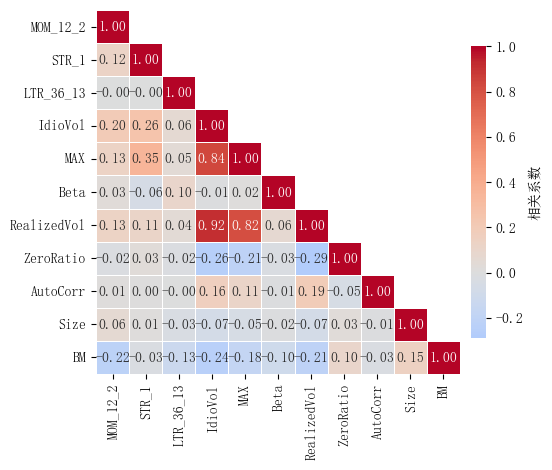

In [14]:
# 创建掩膜，只显示下三角部分（不包括对角线）
mask = np.triu(np.ones_like(df_factor.corr(), dtype=bool), k=1)

heatmap(df_factor.corr(), 
        mask=mask,  # 显示下三角部分
        annot=True,  # 显示数值
        fmt='.2f',   # 数值格式，保留两位小数
        cmap='coolwarm',  # 红蓝渐变色，反转使得红色为正相关，蓝色为负相关
        center=0,    # 色彩中心点为0
        square=True, # 单元格为正方形
        linewidths=0.5,  # 单元格边界线宽
        linecolor='white',  # 边界线颜色
        cbar_kws={
        'shrink': 0.8,  # 颜色条尺寸
        'label': '相关系数',  # 颜色条标签
        'pad': 0.02  # 颜色条与热力图的间距
        }
)

# 调整布局
plt.tight_layout()
# 保存图片
plt.savefig("normal_lasso_result/因子热力图.pdf", 
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

## lasso 分析结果

### 读取信息

In [2]:
# 读取结果
res_path = "normal_lasso_result/lasso_results.pkl"
lasso_res = load_results_pickle(res_path)

已从 normal_lasso_result/lasso_results.pkl 加载结果


In [23]:
lasso_res.keys()

dict_keys(['results_df', 'models_info', 'factor_summary', 'nonlinear_df'])

In [ ]:
# 回归结果
lasso_res['results_df']

,window_id,train_start,train_end,test_start,test_end,n_train_samples,n_test_samples,n_total_features,n_selected_features,train_r2,test_r2,test_rmse,avg_monthly_r2,alpha,selected_features
0,1,2005-01-01,2018-08-01,2018-09-01,2021-02-01,69138,29437,132,20,0.482089,0.558312,0.075244,0.385098,0.000796,"[MOM_12_2_spline_10, MOM_12_2_spline_11, STR_1..."
1,2,2007-03-01,2021-02-01,2021-03-01,2022-10-01,98467,36011,132,22,0.525669,0.618594,0.085989,0.567941,0.000697,"[MOM_12_2_spline_10, MOM_12_2_spline_11, STR_1..."
2,3,2008-04-01,2022-10-01,2022-11-01,2023-10-01,134192,44914,132,28,0.594993,0.693220,0.056166,0.625835,0.000491,"[MOM_12_2_spline_10, MOM_12_2_spline_11, STR_1..."


In [ ]:
# 模型信息
lasso_res['models_info'][0].keys()

dict_keys(['window_id', 'model', 'scaler', 'feature_names', 'feature_details', 'spline_info', 'train_months', 'test_months', 'train_data', 'test_data'])

In [ ]:
# 因子摘要
lasso_res['factor_summary']

,selection_count,avg_abs_coef
factor,,
STR_1,30.0,0.019505
ZeroRatio,23.0,0.003063
MOM_12_2,6.0,0.000461
IdioVol,4.0,0.001082
AutoCorr,2.0,0.000762
RealizedVol,2.0,0.000644
Size,2.0,0.000032
BM,1.0,0.000085


In [ ]:
# 非线性
lasso_res['nonlinear_df']

,factor,selection_count,has_spline,has_linear,max_coef,is_nonlinear
1,STR_1,30,True,False,0.059967,True
3,ZeroRatio,23,True,False,0.019028,True
0,MOM_12_2,6,True,False,0.001076,True
2,IdioVol,4,True,False,0.002562,True
4,RealizedVol,2,True,False,0.001282,True
5,AutoCorr,2,True,False,0.001233,True
6,Size,2,True,False,0.000052,True
7,BM,1,True,False,0.000085,True


### 时间窗口信息整理

In [24]:
windows = lasso_res['results_df'][ 
    ['window_id', 'train_start', 'train_end', 'test_start', 'test_end', 'n_train_samples', 'n_test_samples']
].copy()

# 转换日期格式
for col in ['train_start', 'train_end', 'test_start', 'test_end']: 
    windows[col] = windows[col].dt.strftime('%Y-%m')

# 合并起始
windows['train'] = windows['train_start'] + ' - ' + windows['train_end']
windows['test'] = windows['test_start'] + ' - ' + windows['test_end']

# 删除多余列
windows = windows[ 
    ['window_id', 'train', 'n_train_samples', 'test', 'n_test_samples']
]

windows.columns = ['窗口', '训练期间', '训练样本数', '测试期间', '测试样本数']

print(windows.to_latex(column_format='ccccc', index=False))

\begin{tabular}{ccccc}
\toprule
窗口 & 训练期间 & 训练样本数 & 测试期间 & 测试样本数 \\
\midrule
1 & 2005-01 - 2018-08 & 69138 & 2018-09 - 2021-02 & 29437 \\
2 & 2007-03 - 2021-02 & 98467 & 2021-03 - 2022-10 & 36011 \\
3 & 2008-04 - 2022-10 & 134192 & 2022-11 - 2023-10 & 44914 \\
\bottomrule
\end{tabular}



### LASSO 结果整理和呈现

In [9]:
reg_res = lasso_res['results_df'][ 
    [ 'window_id', 'n_total_features', 'n_selected_features', 'train_r2', 'test_r2', 'test_rmse', 'avg_monthly_r2', 'alpha' ]
].copy()

reg_res[['window_id', 'n_total_features', 'n_selected_features']] = reg_res[['window_id', 'n_total_features', 'n_selected_features']].astype("int")
reg_res[['n_total_features', 'n_selected_features']] = reg_res[['n_total_features', 'n_selected_features']].astype("str")

# reg_res = reg_res.set_index('window_id').T

reg_res['alpha'] = reg_res['alpha'] * 1e3

reg_res.columns= ['窗口', '总特征数', '选中特征数', '训练集 $R^2$', '测试集 $R^2$', '测试集 RMSE', '平均月度 $R^2$', '$\\alpha \\times 10^{3}$' ]

reg_res = reg_res.set_index('窗口')

reg_res

,总特征数,选中特征数,训练集 $R^2$,测试集 $R^2$,测试集 RMSE,平均月度 $R^2$,$\alpha \times 10^{3}$
窗口,,,,,,,
1,132,20,0.482089,0.558312,0.075244,0.385098,0.796353
2,132,22,0.525669,0.618594,0.085989,0.567941,0.697305
3,132,28,0.594993,0.693220,0.056166,0.625835,0.490782


In [10]:
print( reg_res.T.to_latex(float_format="%.3f", column_format='cccc' , index=True) )

\begin{tabular}{cccc}
\toprule
窗口 & 1 & 2 & 3 \\
\midrule
总特征数 & 132 & 132 & 132 \\
选中特征数 & 20 & 22 & 28 \\
训练集 $R^2$ & 0.482 & 0.526 & 0.595 \\
测试集 $R^2$ & 0.558 & 0.619 & 0.693 \\
测试集 RMSE & 0.075 & 0.086 & 0.056 \\
平均月度 $R^2$ & 0.385 & 0.568 & 0.626 \\
$\alpha \times 10^{3}$ & 0.796 & 0.697 & 0.491 \\
\bottomrule
\end{tabular}



### 特征选择结果整理

In [30]:
selection = lasso_res['factor_summary']

selection = ( 
    selection
    .reset_index()
    .assign(factor=lambda x: x['factor'].str.replace('_', '\_'))
    .rename(columns={'factor': '特征因子', 'selection_count': '选中次数', 'avg_abs_coef': '平均绝对系数'})
    .astype({'选中次数': 'int', '平均绝对系数': 'float'})
)

print( 
    selection.to_latex( 
        float_format="%.6f", 
        caption='因子选择结果 (全三轮)',
        label='tab:factor_selection',
        position='h!',
        column_format='lcc',
        index=False
    )
)

\begin{table}[h!]
\caption{因子选择结果 (全三轮)}
\label{tab:factor_selection}
\begin{tabular}{lcc}
\toprule
特征因子 & 选中次数 & 平均绝对系数 \\
\midrule
STR\_1 & 30 & 0.019505 \\
ZeroRatio & 23 & 0.003063 \\
MOM\_12\_2 & 6 & 0.000461 \\
IdioVol & 4 & 0.001082 \\
AutoCorr & 2 & 0.000762 \\
RealizedVol & 2 & 0.000644 \\
Size & 2 & 0.000032 \\
BM & 1 & 0.000085 \\
\bottomrule
\end{tabular}
\end{table}



### 非线性效应分析

In [18]:
lasso_res['nonlinear_df'].reset_index()

,index,factor,selection_count,has_spline,has_linear,max_coef,is_nonlinear
0,1,STR_1,30,True,False,0.059967,True
1,3,ZeroRatio,23,True,False,0.019028,True
2,0,MOM_12_2,6,True,False,0.001076,True
3,2,IdioVol,4,True,False,0.002562,True
4,4,RealizedVol,2,True,False,0.001282,True
5,5,AutoCorr,2,True,False,0.001233,True
6,6,Size,2,True,False,0.000052,True
7,7,BM,1,True,False,0.000085,True


In [29]:
print( 
    lasso_res['nonlinear_df']
    .reset_index()
    .drop(columns=['index', 'has_spline', 'has_linear'])
    .assign(is_nonlinear=lambda x: x['is_nonlinear'].map({True: '非线性', False: '线性'}))
    .assign(factor=lambda x: x['factor'].str.replace('_', '\_'))
    .rename(columns={ 
        'factor': '特征因子',
        'selection_count': '被选中次数',
        'max_coef': '最大绝对系数',
        'is_nonlinear': '效应类型'
    })
    .to_latex(
        float_format="%.6f",
        caption='非线性效应分析结果',
        label='tab:nonlinear_analysis',
        position='h!',
        column_format='lcccc',
        index=False
    )
)

\begin{table}[h!]
\caption{非线性效应分析结果}
\label{tab:nonlinear_analysis}
\begin{tabular}{lcccc}
\toprule
特征因子 & 被选中次数 & 最大绝对系数 & 效应类型 \\
\midrule
STR\_1 & 30 & 0.059967 & 非线性 \\
ZeroRatio & 23 & 0.019028 & 非线性 \\
MOM\_12\_2 & 6 & 0.001076 & 非线性 \\
IdioVol & 4 & 0.002562 & 非线性 \\
RealizedVol & 2 & 0.001282 & 非线性 \\
AutoCorr & 2 & 0.001233 & 非线性 \\
Size & 2 & 0.000052 & 非线性 \\
BM & 1 & 0.000085 & 非线性 \\
\bottomrule
\end{tabular}
\end{table}



### 边际效应曲面

In [36]:
from patsy import dmatrix

def reconstruct_marginal_effect(feature_name, model_info, n_points=100):
        """
        重构一个特征的边际效应函数（条件关系）
        
        参数：
        feature_name: 特征名
        model_info: 单个窗口的模型信息
        n_points: 网格点数
        fixed_at_median: 是否将其他特征固定在中间值
        
        返回：
        x_grid: 特征值网格（标准化后的排名）
        y_effect: 边际效应值
        """
        try:
            # 检查该特征是否在模型中
            spline_info = model_info['spline_info'].get(feature_name)
            if not spline_info:
                print(f"特征 {feature_name} 未在样条信息中找到")
                return None, None
            
            # 创建特征值网格
            x_grid = np.linspace(0.01, 0.99, n_points)
            
            # 创建该特征的基函数
            if spline_info['spline_type'] == 'linear':
                # 线性特征
                basis_values = x_grid.reshape(-1, 1)
                basis_names = spline_info['spline_cols']
            else:
                # 样条特征
                basis_df = pd.DataFrame({'x': x_grid})
                try:
                    basis_matrix = dmatrix(
                        spline_info['formula'],
                        {"x": basis_df['x']}, 
                        return_type='dataframe'
                    )
                    if basis_matrix.shape[1] == len(spline_info['spline_cols']):
                        basis_matrix.columns = spline_info['spline_cols']
                        basis_values = basis_matrix.values
                        basis_names = spline_info['spline_cols']
                    else:
                        print(f"基函数维度不匹配: {feature_name}")
                        return None, None
                except Exception as e:
                    print(f"创建基函数失败: {feature_name}, {e}")
                    return None, None
            
            # 获取系数
            coefficients = []
            for basis_name in basis_names:
                if basis_name in model_info['feature_details']:
                    coefficients.append(model_info['feature_details'][basis_name]['coefficient'])
                else:
                    coefficients.append(0)
            
            coefficients = np.array(coefficients)
            
            # 计算边际效应
            if basis_values.shape[1] == len(coefficients):
                y_effect = basis_values @ coefficients
            else:
                # 维度匹配
                min_dim = min(basis_values.shape[1], len(coefficients))
                y_effect = basis_values[:, :min_dim] @ coefficients[:min_dim]
            
            return x_grid, y_effect
            
        except Exception as e:
            print(f"重构边际效应失败: {feature_name}, {e}")
            return None, None
        
        
def plot_3d_time_varying_effect(feature_name, models_info, view_rotate=[25, -165], save_path=None):
    """
    绘制3D时间变化图：x轴=特征值，y轴=时间，z轴=预期收益
    
    参数：
    feature_name: 要分析的特征
    models_info: 所有窗口的模型信息
    """
    import matplotlib.pyplot as plt
    # from mpl_toolkits.mplot3d import Axes3D
    from matplotlib import cm
    
    # 收集数据
    time_points = []
    feature_grids = []
    expected_returns = []
    
    for model_info in models_info:
        # 时间点（窗口中间点）
        train_months = model_info['train_months']
        time_point = train_months[len(train_months)//2]  # 取训练期中间月份
        
        # 特征网格（0-1）
        feature_grid = np.linspace(0.01, 0.99, 50)
        
        # 计算边际效应（预期收益）
        _, y_effect = reconstruct_marginal_effect(
            feature_name, model_info, n_points=50
        )
        
        if y_effect is not None:
            time_points.append(time_point)
            feature_grids.append(feature_grid)
            expected_returns.append(y_effect)
    
    # 转换为数组
    X, Y = np.meshgrid(feature_grids[0], range(len(time_points)))
    Z = np.array(expected_returns)
    
    # 创建3D图
    fig = plt.figure(figsize=(7,7), facecolor='white')
    ax = fig.add_subplot(111, projection='3d', facecolor='white')
    
    # 绘制曲面
    surf = ax.plot_surface(
        X, Y, Z,
        cmap=cm.viridis,
        # edgecolor='lightgray',
        linewidth=0,
        antialiased=True,
        alpha=0.9
    )

    # 设置背景为纯白色
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))  # X轴平面
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))  # Y轴平面
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))  # Z轴平面

    # 设置轴线颜色为黑色
    ax.xaxis.line.set_color('black')
    ax.yaxis.line.set_color('black')
    ax.zaxis.line.set_color('black')

    # 网格线设置
    ax.grid(True, alpha=0.1, linestyle='-', linewidth=0.3, color='gray')
    
    # 设置标签
    ax.set_xlabel(f'{feature_name} (排名百分位)', fontsize=12, labelpad=10)
    ax.set_ylabel('时间窗口', fontsize=12, labelpad=10)
    ax.set_zlabel('预期超额收益（边际效应）', fontsize=12, labelpad=10)
    
    # 设置标题
    # ax.set_title(f'{feature_name}边际效应的时间变化（控制其他特征）', 
                #  fontsize=16, pad=20)
    
    # 添加颜色条
    # fig.colorbar(surf, shrink=0.5, aspect=5, label='预期收益')
    
    # 调整视角
    # ax.view_init(elev=25, azim=-45)
    
    # 紧凑
    plt.subplots_adjust(left=2, right=6, bottom=0.1, top=0.2)
    plt.tight_layout(pad=5.0) 

    # 调整视角
    ax.view_init(elev=view_rotate[0], azim=view_rotate[1])

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"结果已保存于 {save_path}")
    
    plt.show()

结果已保存于 normal_lasso_result/time_varying_effect_STR_1.pdf


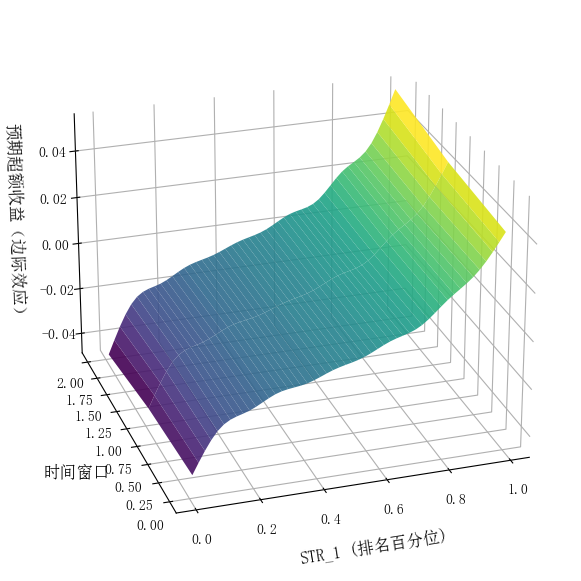

In [37]:
save_path = f"normal_lasso_result/time_varying_effect_STR_1.pdf"

plot_3d_time_varying_effect( 
    'STR_1', 
    lasso_res['models_info'], 
    [25, -108], 
    save_path
)

结果已保存于 normal_lasso_result/time_varying_effect_ZeroRatio.pdf


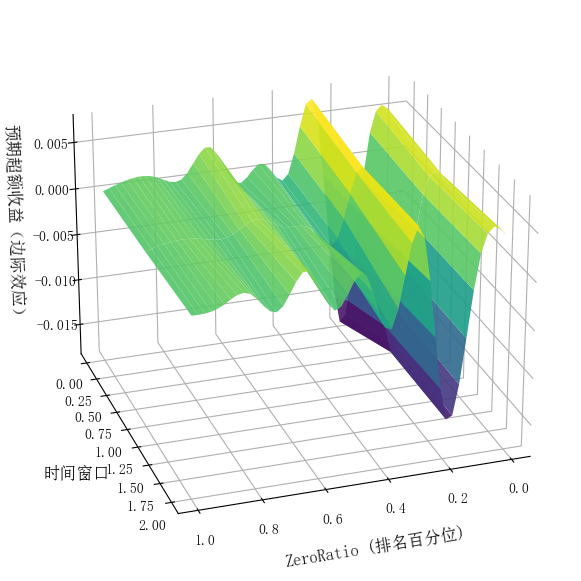

In [38]:
save_path = f"normal_lasso_result/time_varying_effect_ZeroRatio.pdf"

plot_3d_time_varying_effect( 
    'ZeroRatio', 
    lasso_res['models_info'], 
    [25, 71.5], 
    save_path
)